# RAMP on predicting cyclist traffic in Paris


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [74]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [75]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), int64(

and in particular the number of unique entries in each column,

In [77]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [78]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [79]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

<Axes: xlabel='date'>

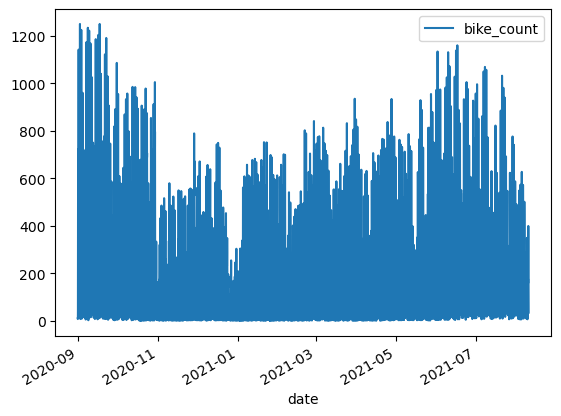

In [80]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

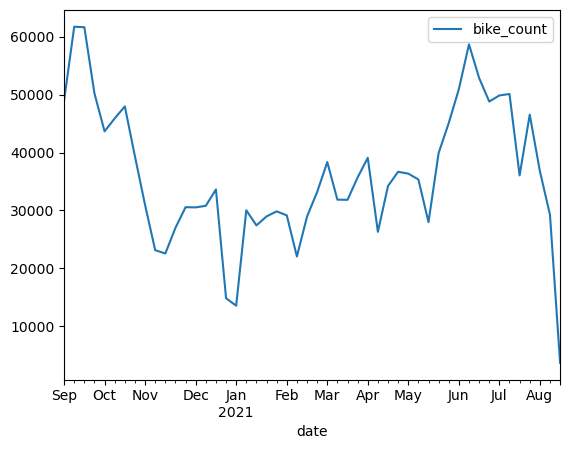

In [81]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

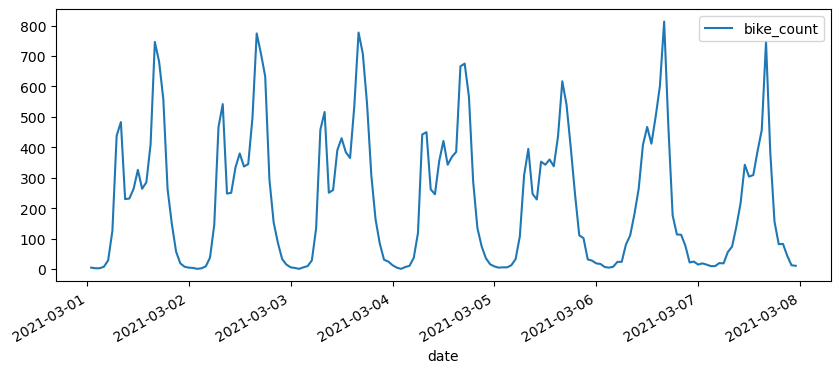

In [82]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

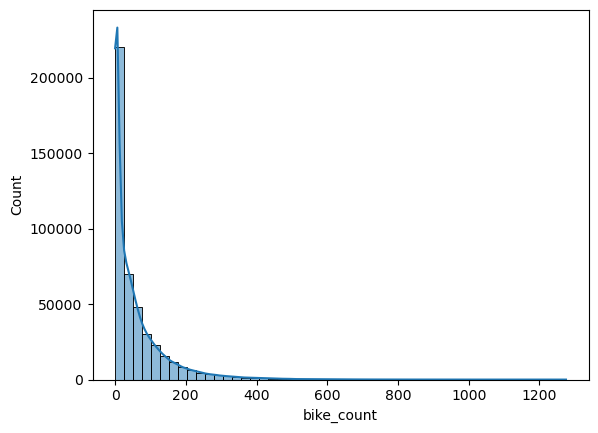

In [83]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

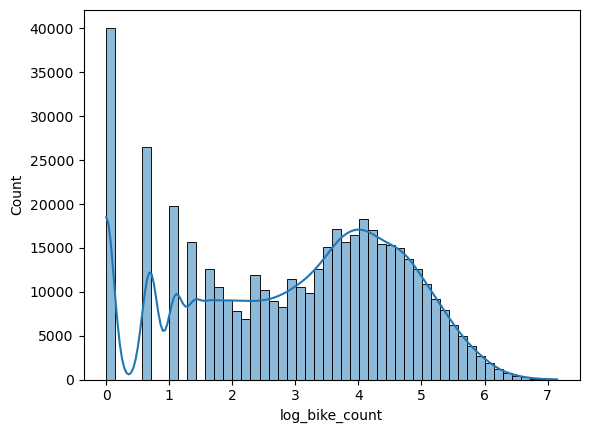

In [84]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [85]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [86]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[ns]

In [87]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [88]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [89]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [90]:
import utils

X, y = utils.get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233


and

In [47]:
y

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [48]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [49]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=414843,  2020-09-01 01:00:00 to 2021-07-10 23:00:00
Valid: n_samples=40320,  2021-07-11 00:00:00 to 2021-08-09 23:00:00


In [50]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001B3D33FAFC0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [52]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.85


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [53]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.70
Test set, RMSE=1.42


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [54]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

Text(0, 0.5, 'bike_count')

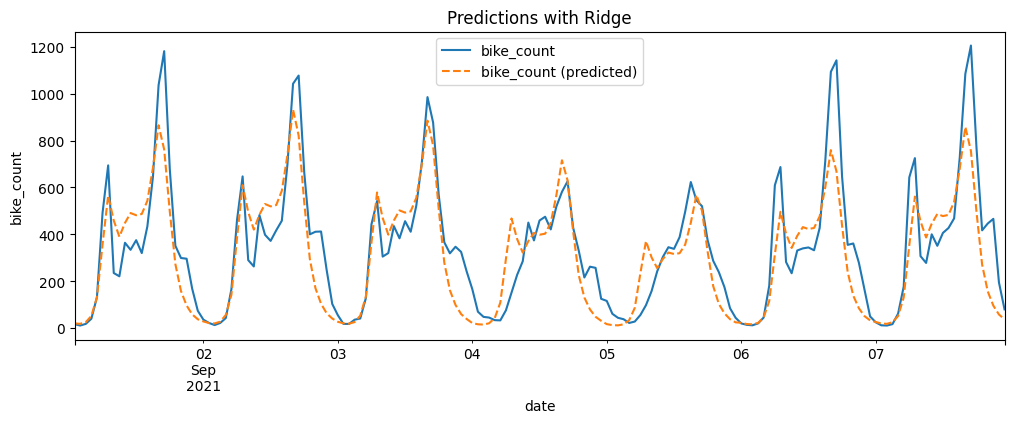

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

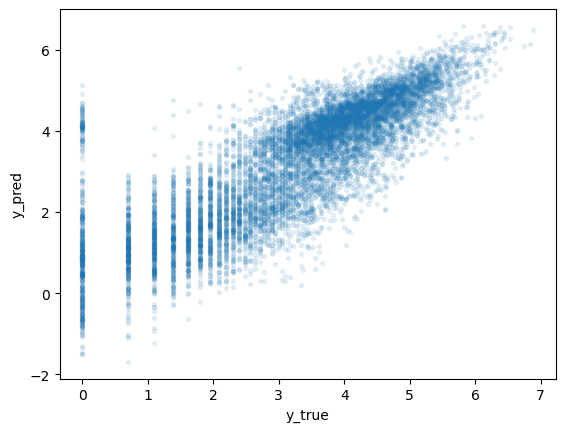

In [55]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [56]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.99836302 -0.8478686  -0.91118938 -0.77449455 -0.97062446 -1.13838288]
RMSE (all folds): 0.94 ± 0.116


In [57]:
y_pred = pipe.predict(X_test)
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)

NameError: name 'X_test' is not defined

## Adding new features

In [201]:
data_csv = pd.read_parquet("data/train.parquet")
data_csv.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [202]:
external_data = pd.read_csv("external_data/external_data.csv")
external_data.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


We add new features by merging data_csv and external_data:

In [203]:
# Convert the 'date' columns in both datasets to datetime for alignment
data_csv['date'] = (pd.to_datetime(data_csv['date'])).astype('datetime64[ns]')
external_data['date'] = (pd.to_datetime(external_data['date'])).astype('datetime64[ns]')

# Interpolating and backward filling the external data

# Selecting continuous and categorical columns
continuous_cols = external_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = external_data.select_dtypes(exclude=['float64', 'int64']).columns

external_data_interpolated = external_data.copy()
external_data_interpolated = external_data_interpolated.sort_values('date')
external_data_interpolated[continuous_cols] = external_data_interpolated[continuous_cols].interpolate()
external_data_interpolated[categorical_cols] = external_data_interpolated[categorical_cols].bfill()

# Merging the datasets without setting 'date' as the index
merged_data = pd.merge_asof(data_csv.sort_values('date'), 
                                     external_data_interpolated.sort_values('date'),
                                     on='date', 
                                     direction='nearest')

In [204]:
def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 16:
        return "afternoon"
    elif 16 <= hour < 20:
        return "evening"
    else:
        return "night"
    
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["hour"] = X["date"].dt.hour
    X["day_of_week"] = X["date"].dt.dayofweek
    X["month"] = X["date"].dt.month
    X['is_weekend'] = X['day_of_week'].isin([5, 6]).astype(int)  # 0 for weekdays, 1 for weekends
    X['is_night'] = X['hour'].apply(lambda x: 1 if (x < 6 or x >= 20) else 0)  # Assuming night is 8PM to 6AM


    # Finally we can drop the original columns from the dataframe
    return X

We decided to add temperature, humidity, wind_speed and precipitation and to extract the following from the date: year, month, day of the week, weekday (or weekend), hour and time of the day(morning, afternoon, evening, night):

In [205]:
# Keeping all features from the original train.csv
original_features = data_csv.columns.tolist()
weather_features = ['t', 'u', 'ff', 'rr3', 'rr6', 'rr12', 'rr24']  # temperature, humidity, wind speed, precipitation

# Discarding only the irrelevant features from external_data
irrelevant_external_features = [col for col in merged_data.columns if col not in original_features and col not in weather_features]
merged_data.drop(irrelevant_external_features, axis=1, inplace=True)

merged_data = _encode_dates(merged_data)

weather_features_names = {
    't': 'temperature',
    'u': 'humidity',
    'ff': 'wind_speed',
    'rr3': 'precipitation_3h',
    'rr6' : 'precipitation_6h',
    'rr12' : 'precipitation_12h',
    'rr24' : 'precipitation_24h'
}
merged_data.rename(columns=weather_features_names, inplace=True)
merged_data['time_of_day'] = merged_data['hour'].apply(assign_time_of_day)

merged_data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,precipitation_3h,precipitation_6h,precipitation_12h,precipitation_24h,hour,day_of_week,month,is_weekend,is_night,time_of_day
0,100056332-104056332,Pont de Bercy SO-NE,100056332,Pont de Bercy,0.0,2020-09-01 01:00:00,2019-12-11,Y2H19070378,48.83848,2.37587,...,0.0,0.0,0.0,0.0,1,1,9,0,1,night
1,100047547-104047547,6 rue Julia Bartet NE-SO,100047547,6 rue Julia Bartet,4.0,2020-09-01 01:00:00,2018-11-28,Y2H18086323,48.82636,2.30303,...,0.0,0.0,0.0,0.0,1,1,9,0,1,night
2,100047547-103047547,6 rue Julia Bartet SO-NE,100047547,6 rue Julia Bartet,2.0,2020-09-01 01:00:00,2018-11-28,Y2H18086323,48.82636,2.30303,...,0.0,0.0,0.0,0.0,1,1,9,0,1,night
3,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,0.0,2020-09-01 01:00:00,2020-02-11,YTH19111509,48.86462,2.31444,...,0.0,0.0,0.0,0.0,1,1,9,0,1,night
4,100047548-103047548,Face au 25 quai de l'Oise NE-SO,100047548,Face au 25 quai de l'Oise,2.0,2020-09-01 01:00:00,2018-11-28,Y2H18086324,48.89141,2.38482,...,0.0,0.0,0.0,0.0,1,1,9,0,1,night


## Preprocessing the features

In [206]:
# Initializing input matrix X and target vector y

merged_data = merged_data.sort_values(["date", "counter_name"])

X = merged_data.drop(['date', 'bike_count', 'log_bike_count', 'counter_id', 'site_id', 'counter_installation_date', 'counter_technical_id'], axis=1)
y = merged_data['log_bike_count']

In [207]:
# OneHot encoding for categorical variables

categorical_columns = ['site_name', 'counter_name', 'time_of_day']
X = pd.get_dummies(X, columns=categorical_columns)

# Scaling for numerical variables

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_columns = ['latitude', 'longitude', 'wind_speed','temperature','humidity','precipitation_3h', 'precipitation_6h', 'precipitation_12h', 'precipitation_24h']
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

X.head()

,latitude,longitude,wind_speed,temperature,humidity,precipitation_3h,precipitation_6h,precipitation_12h,precipitation_24h,hour,...,counter_name_Totem 85 quai d'Austerlitz NO-SE,counter_name_Totem 85 quai d'Austerlitz SE-NO,counter_name_Totem Cours la Reine E-O,counter_name_Totem Cours la Reine O-E,counter_name_Voie Georges Pompidou NE-SO,counter_name_Voie Georges Pompidou SO-NE,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
8,0.220946,0.470042,0.125984,0.454774,0.75,0.00495,0.004202,0.002967,0.002475,1,...,False,False,False,False,False,False,False,False,False,True
15,0.220946,0.470042,0.125984,0.454774,0.75,0.00495,0.004202,0.002967,0.002475,1,...,False,False,False,False,False,False,False,False,False,True
21,0.418605,0.634921,0.125984,0.454774,0.75,0.00495,0.004202,0.002967,0.002475,1,...,False,False,False,False,False,False,False,False,False,True
23,0.418605,0.634921,0.125984,0.454774,0.75,0.00495,0.004202,0.002967,0.002475,1,...,False,False,False,False,False,False,False,False,False,True
25,0.901622,0.424482,0.125984,0.454774,0.75,0.00495,0.004202,0.002967,0.002475,1,...,False,False,False,False,False,False,False,False,False,True


## Merging & preprocessing X_test

In [208]:
X_final_test = pd.read_parquet("data/final_test.parquet")


# Merging external_data with X_final_test

# Convert the 'date' columns in both datasets to datetime for alignment
X_final_test['date'] = (pd.to_datetime(X_final_test['date'])).astype('datetime64[ns]')

X_final_test = X_final_test.reset_index()

original_features = X_final_test.columns.tolist()
weather_features = ['t', 'u', 'ff', 'rr3', 'rr6', 'rr12', 'rr24']  # temperature, humidity, wind speed, precipitation

# Merging the datasets without setting 'date' as the index
X_final_test = pd.merge_asof(X_final_test.sort_values('date'), 
                                     external_data_interpolated.sort_values('date'),
                                     on='date', 
                                     direction='nearest')


# Discarding only the irrelevant features from external_data
irrelevant_external_features = [col for col in X_final_test.columns if col not in original_features and col not in weather_features]
X_final_test.drop(irrelevant_external_features, axis=1, inplace=True)

X_final_test = _encode_dates(X_final_test)

weather_features_names = {
    't': 'temperature',
    'u': 'humidity',
    'ff': 'wind_speed',
    'rr3': 'precipitation_3h',
    'rr6' : 'precipitation_6h',
    'rr12' : 'precipitation_12h',
    'rr24' : 'precipitation_24h'
}
X_final_test.rename(columns=weather_features_names, inplace=True)
X_final_test['time_of_day'] = X_final_test['hour'].apply(assign_time_of_day)

# Drop non-relevant features

X_final_test = X_final_test.drop(['date', 'counter_id', 'site_id', 'counter_installation_date', 'counter_technical_id','coordinates'], axis=1)

# Preprocessing

categorical_columns = ['site_name', 'counter_name', 'time_of_day']
X_final_test = pd.get_dummies(X_final_test, columns=categorical_columns)

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
numerical_columns = ['latitude', 'longitude', 'wind_speed','temperature','humidity','precipitation_3h', 'precipitation_6h', 'precipitation_12h', 'precipitation_24h']
X_final_test[numerical_columns] = scaler.fit_transform(X_final_test[numerical_columns])

X_final_test.sort_values(by = 'index', inplace=True)
X_final_test.drop(columns='index', inplace=True)


In [209]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=42, verbose=10, n_jobs=-1)
regressor.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, regressor.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_test, regressor.predict(X_test), squared=False):.2f}"
)

In [ ]:
y_pred = regressor.predict(X_final_test)
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("Random_forest_8.csv", index=False)

Using the whole dataset to train the regressor to get the best score

In [68]:
X = merged_data.drop(['date', 'bike_count', 'log_bike_count', 'counter_id', 'site_id', 'counter_installation_date', 'counter_technical_id'], axis=1)
y = merged_data['log_bike_count'].values

In [ ]:
categorical_columns = ['site_name', 'counter_name', 'time_of_day']
X = pd.get_dummies(X, columns=categorical_columns)

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
numerical_columns = ['latitude', 'longitude', 'wind_speed','temperature','humidity','precipitation']
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

X

In [ ]:
regressor.fit(X,y)

In [ ]:
y_pred = regressor.predict(X_final_test)
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("Random_forest_9.csv", index=False)

## Gradient Boosting

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Model selection and training - using Gradient Boosting for better memory efficiency
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_gb = gb_model.predict(X_valid)

# Evaluating the model
mse_gb = mean_squared_error(y_valid, y_pred_gb)
r2_gb = r2_score(y_valid, y_pred_gb)

mse_gb, r2_gb

(0.5587983030661592, 0.8012463468876175)

## LightGBM

In [210]:
import lightgbm as lgb
from sklearn.metrics import r2_score


# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Define the parameters for the model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'max_bin': 255,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 1,
    'min_child_weight': 0.001,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 4,
    'verbose': 0
}

# Train the model
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)

# Evaluate the model
mse_lgbm = mean_squared_error(y_valid, y_pred)
r2_lgbm = r2_score(y_valid, y_pred)

print(f"Mean Squared Error: {mse_lgbm}")
print(f"R-squared: {r2_lgbm}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Mean Squared Error: 0.18363824235828977
R-squared: 0.9346834603477208


In [211]:
# Train on the TOTAL data before submitting if 
train_data = lgb.Dataset(X, label=y)

# Define the parameters for the model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'max_bin': 255,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 1,
    'min_child_weight': 0.001,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 4,
    'verbose': 0
}

# Train the model
num_round = 1000
bst = lgb.train(params, train_data, num_round) 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [177]:
y_pred = bst.predict(X_final_test, num_iteration=bst.best_iteration)

In [212]:
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission_LGB_weekend.csv", index=False)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the model
model = LGBMRegressor()

# Define the parameters for grid search
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Define the grid search
grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid.best_params_)
print("Best score found: ", np.sqrt(-grid.best_score_))

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


KeyboardInterrupt: 

In [ ]:
# Use the best parameters to make predictions
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the predictions
mse_lgbm = mean_squared_error(y_test, y_pred)
r2_lgbm = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse_lgbm}")
print(f"R-squared: {r2_lgbm}")


In [ ]:
full_model = lgb.LGBMRegressor(grid.best_params_)
full_model.fit(X, y)


In [ ]:
model = lgb.LGBMRegressor()
model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 455163, number of used features: 101
[LightGBM] [Info] Start training from score 3.048589


LGBMRegressor()

In [ ]:
y_pred = model.predict(X_final_test)

results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission_LGB2.csv", index=False)

## XGBoost

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'reg:squarederror',  # for regression problems
    'eval_metric': 'rmse',             # root mean squared error
    'eta': 0.15,                        # learning rate
    'max_depth': 10,
    'subsample': 1,
    'colsample_bytree': 0.8
}

model = xgb.train(params, dtrain, num_boost_round = 100, evals=[(dvalid, 'validation')])
dtest = xgb.DMatrix(X_valid)
y_pred = model.predict(dtest)

rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Root Mean Squared Error on Validation Set: {rmse}')

[0]	validation-rmse:1.48646
[1]	validation-rmse:1.36811
[2]	validation-rmse:1.27445
[3]	validation-rmse:1.15382
[4]	validation-rmse:1.09015
[5]	validation-rmse:1.04325
[6]	validation-rmse:0.96302
[7]	validation-rmse:0.89673
[8]	validation-rmse:0.84239
[9]	validation-rmse:0.79137
[10]	validation-rmse:0.75458
[11]	validation-rmse:0.72584
[12]	validation-rmse:0.69735
[13]	validation-rmse:0.67185
[14]	validation-rmse:0.65503
[15]	validation-rmse:0.64092
[16]	validation-rmse:0.62528
[17]	validation-rmse:0.61617
[18]	validation-rmse:0.60356
[19]	validation-rmse:0.59629
[20]	validation-rmse:0.58800
[21]	validation-rmse:0.58112
[22]	validation-rmse:0.57327
[23]	validation-rmse:0.56561
[24]	validation-rmse:0.55382
[25]	validation-rmse:0.54797
[26]	validation-rmse:0.54451
[27]	validation-rmse:0.53809
[28]	validation-rmse:0.52611
[29]	validation-rmse:0.52343
[30]	validation-rmse:0.51836
[31]	validation-rmse:0.51680
[32]	validation-rmse:0.50525
[33]	validation-rmse:0.50322
[34]	validation-rmse:0.4

In [ ]:
d_final_test = xgb.DMatrix(X_final_test)
y_pred = model.predict(d_final_test)

In [ ]:
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission_XGB.csv", index=False)